<a href="https://colab.research.google.com/github/karishmasandupatla/google-trends-pytrends-analysis/blob/main/Google_search_Analyser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Google Search Analyzer**
###This notebook analyzes Google Search Trends data collected via Pytrends.
###It performs data loading, cleaning, statistical analysis, and visualization to identify seasonal patterns and trends in search queries.
###Dataset Source: Google Trends API (via Pytrends library)

#**1. Install & Import Libraries**


In [ ]:
# Install dependencies
!pip install pytrends

#**2. Data Loading**

##**Google** Search Education data Fetch from Pytrends *module*

In [ ]:
from pytrends.request import TrendReq
import pandas as pd
import os
import time
from datetime import datetime

# === Config === #
TIMEFRAME = 'today 12-m'  # last 12 months
GEO = 'IN'  # India
SLEEP_TIME = 2
OUTPUT_DIR = "ne_trend_data"

# Only Education category
categories = {
    "Education": ["Online Courses", "GATE Exam", "Data Science", "NEET"]
}

os.makedirs(OUTPUT_DIR, exist_ok=True)
pytrends = TrendReq(hl='en-US', tz=360)

def fetch_all_data(category, keywords):
    print(f"[{datetime.now()}] 🔍 Fetching all data for category: {category}")
    base_path = os.path.join(OUTPUT_DIR, category.lower().replace(' ', '_'))
    os.makedirs(base_path, exist_ok=True)

    def safe_save(df, filename):
        if df is not None and not df.empty:
            df.to_csv(os.path.join(base_path, filename))
            print(f"Saved {filename}")
        else:
            print(f"No data to save for {filename}")

    try:
        pytrends.build_payload(keywords, timeframe=TIMEFRAME, geo=GEO)
    except Exception as e:
        print(f"Failed to build payload for {category}: {e}")
        return

    def safe_fetch(fetch_func, name):
        try:
            df = fetch_func()
            if df.empty:
                print(f"No {name} data for {category}")
                return None
            if 'isPartial' in df.columns:
                df = df.drop(columns=['isPartial'])
            return df
        except Exception as e:
            print(f"Error fetching {name} for {category}: {e}")
            return None

    # Interest over time
    df_time = safe_fetch(pytrends.interest_over_time, 'interest over time')
    safe_save(df_time, 'interest_over_time.csv')

    # Interest by region (subregion)
    df_region = safe_fetch(lambda: pytrends.interest_by_region(resolution='REGION', inc_low_vol=True), 'interest by region')
    safe_save(df_region, 'interest_by_region.csv')

    # Interest by city
    df_city = safe_fetch(lambda: pytrends.interest_by_region(resolution='CITY', inc_low_vol=True), 'interest by city')
    safe_save(df_city, 'interest_by_city.csv')

    # Related queries (per keyword)
    try:
        related_queries = pytrends.related_queries()
        if not related_queries:
            print(f"No related queries data for {category}")
            related_queries = {}
    except Exception as e:
        print(f"Error fetching related queries for {category}: {e}")
        related_queries = {}

    for kw in keywords:
        rq = related_queries.get(kw, {})
        for rq_type in ['top', 'rising']:
            df_rq = rq.get(rq_type)
            if df_rq is not None and not df_rq.empty:
                filename = f'related_queries_{rq_type}_{kw.replace(" ", "_")}.csv'
                safe_save(df_rq, filename)
            else:
                print(f"No {rq_type} related queries for keyword '{kw}'")

    print(f"Finished fetching all data for {category}\n")

# === Main Execution Loop === #
for cat, kw_list in categories.items():
    fetch_all_data(cat, kw_list)
    time.sleep(SLEEP_TIME)



[2025-08-14 11:20:54.112986] 🔍 Fetching all data for category: Education


/usr/local/lib/python3.11/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


Saved interest_over_time.csv
Saved interest_by_region.csv
Saved interest_by_city.csv
Saved related_queries_top_Online_Courses.csv
Saved related_queries_rising_Online_Courses.csv
No top related queries for keyword 'GATE Exam'
No rising related queries for keyword 'GATE Exam'
Saved related_queries_top_Data_Science.csv
Saved related_queries_rising_Data_Science.csv
Saved related_queries_top_NEET.csv
Saved related_queries_rising_NEET.csv
Finished fetching all data for Education



#**3. Data  Cleaning And Exploratory Data Analysis (EDA)**


###Clean for time data


In [ ]:
import pandas as pd

# === Load the time Google Trends data for Education === #
df = pd.read_csv("/content/drive/MyDrive/Education/interest_over_time (4).csv")

# === Quick Look at the Data === #
print(" First 5 rows:")
print(df.head())

print("\n DataFrame shape (rows, columns):", df.shape)

print("\n Data Types and Structure:")
print(df.info())

print("\n Summary Statistics (numerical columns):")
print(df.describe())

print("\n Column Data Types:")
print(df.dtypes)

# === Date Parsing (if date column exists) === #
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')  # Convert to datetime
    print("\nData Types after datetime conversion:")
    print(df.dtypes)

# === Standardize column names === #
df.columns = df.columns.str.lower().str.strip()

print("\nCleaned column names and first rows:")
print(df.head())

# === Uniqueness Check === #
print("\nUnique value count per column:")
print(df.nunique())

# === Missing Value Check === #
print("\nAny missing values?:", df.isnull().values.any())
print("\n Missing value count per column:")
print(df.isnull().sum())

# === Duplicate Check === #
print("\n Any duplicate rows?:", df.duplicated().values.any())
print(" Number of duplicate rows:", df.duplicated().sum())

# === Save Cleaned Data === #
df.to_csv('/content/drive/MyDrive/Education/clean_time.csv', index=False)



 First 5 rows:
         date  Online Courses  GATE Exam  Data Science  NEET
0  2024-06-09               2          1             5    62
1  2024-06-16               2          1             5    63
2  2024-06-23               3          1             5    47
3  2024-06-30               2          1             5    53
4  2024-07-07               2          1             5    34

 DataFrame shape (rows, columns): (53, 5)

 Data Types and Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            53 non-null     object
 1   Online Courses  53 non-null     int64 
 2   GATE Exam       53 non-null     int64 
 3   Data Science    53 non-null     int64 
 4   NEET            53 non-null     int64 
dtypes: int64(4), object(1)
memory usage: 2.2+ KB
None

 Summary Statistics (numerical columns):
       Online Courses  GATE Exam  Data Sc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**3. Data  Cleaning And Exploratory Data Analysis (EDA)**

###Clean for city data

In [ ]:
import pandas as pd

# === Load the combined city-level Google Trends data === #
df = pd.read_csv("/content/drive/MyDrive/Education/interest_by_city (4).csv")

# === Quick Look at the Data === #
print(" First 5 rows:")
print(df.head())

print("\n DataFrame shape (rows, columns):", df.shape)

print("\n Data Types and Structure:")
print(df.info())

print("\nSummary Statistics (numerical columns):")
print(df.describe())

print("\nColumn Data Types:")
print(df.dtypes)

# === Date Parsing (if date column exists) === #
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')  # Handle errors if any
    print("\n Data Types after datetime conversion:")
    print(df.dtypes)

# === Standardize column names === #
df.columns = df.columns.str.lower().str.strip()

print("\nCleaned column names and first rows:")
print(df.head())

# === Uniqueness Check === #
print("\nUnique value count per column:")
print(df.nunique())

# === Missing Value Check === #
print("\n Any missing values?:", df.isnull().values.any())
print("\n Missing value count per column:")
print(df.isnull().sum())

# === Duplicate Check === #
print("\n Any duplicate rows?:", df.duplicated().values.any())
print("Number of duplicate rows:", df.duplicated().sum())

# === Save Cleaned Data === #
df.to_csv('/content/drive/MyDrive/Education/clean_city.csv', index=False)




 First 5 rows:
                       geoName  Online Courses  GATE Exam  Data Science  NEET
0  Andaman and Nicobar Islands               5          0             4    91
1               Andhra Pradesh               5          5            14    76
2            Arunachal Pradesh               2          2             3    93
3                        Assam               3          3             4    90
4                        Bihar               2          2             4    92

 DataFrame shape (rows, columns): (36, 5)

 Data Types and Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   geoName         36 non-null     object
 1   Online Courses  36 non-null     int64 
 2   GATE Exam       36 non-null     int64 
 3   Data Science    36 non-null     int64 
 4   NEET            36 non-null     int64 
dtypes: int64(4), object(1)
memory u

#**4.Data Visulization**

##**Visuals for interest over time**

In [ ]:
#Visuals for intersnt over time

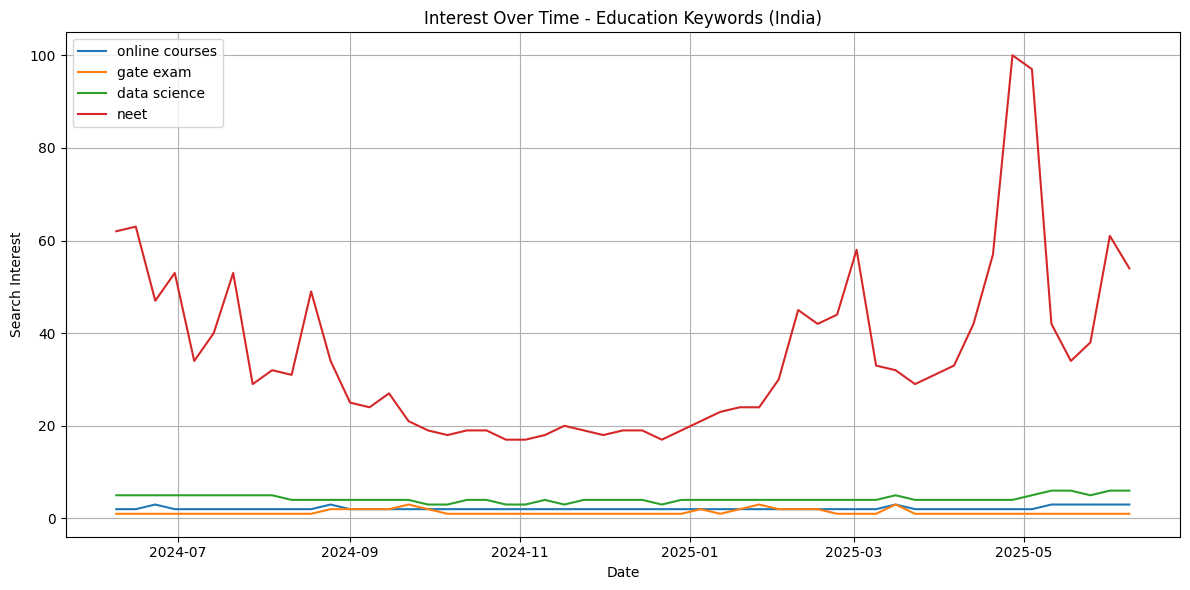

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load interest over time data
df = pd.read_csv("/content/drive/MyDrive/Education/clean_time.csv", index_col=0, parse_dates=True)

# Plot the trends
plt.figure(figsize=(12, 6))
for col in df.columns:
    plt.plot(df.index, df[col], label=col)

plt.title("Interest Over Time - Education Keywords (India)")
plt.xlabel("Date")
plt.ylabel("Search Interest")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Average Interest per Keyword:
 neet              35.396226
data science       4.264151
online courses     2.150943
gate exam          1.301887
dtype: float64

Trend Shape Analysis (slope of trend over time):
Online Courses      : Increasing (slope = 0.00)
Gate Exam           : Decreasing (slope = -0.00)
Data Science        : Increasing (slope = 0.00)
Neet                : Increasing (slope = 0.04)

 Peak Interest Dates per Keyword:
Online Courses      : 2024-06-23 (score = 3)
Gate Exam           : 2024-09-22 (score = 3)
Data Science        : 2025-05-11 (score = 6)
Neet                : 2025-04-27 (score = 100)


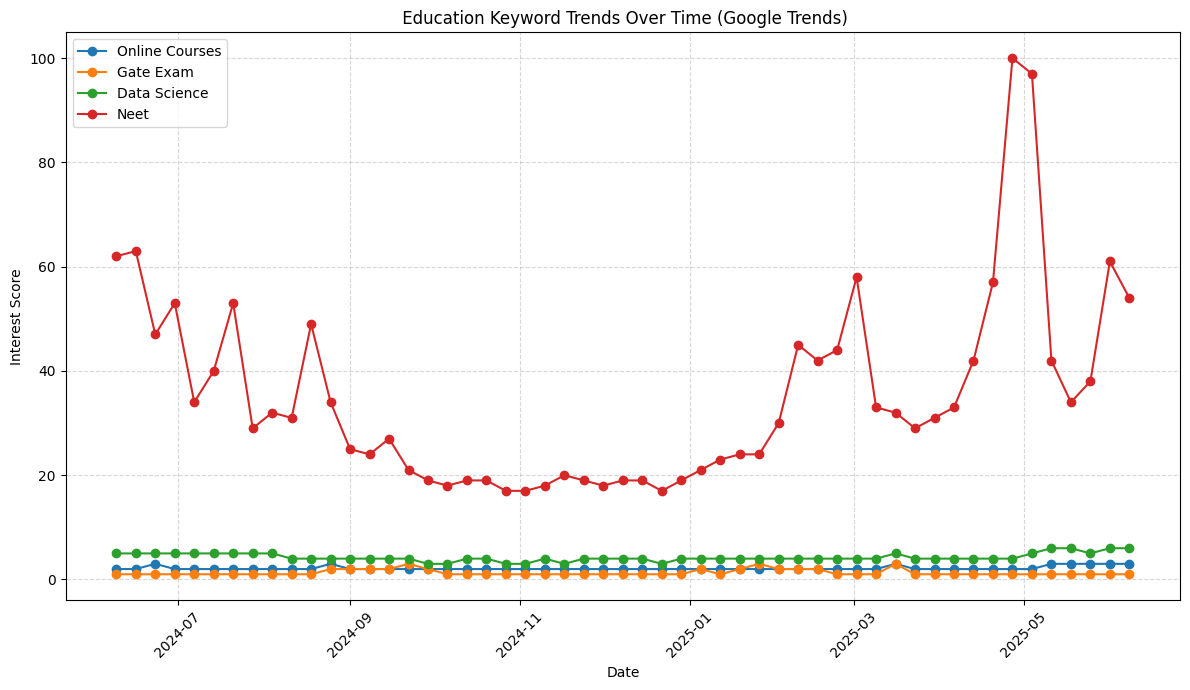

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Load data
df = pd.read_csv('/content/drive/MyDrive/Education/clean_time.csv')
df['date'] = pd.to_datetime(df['date'])

# Drop date for easier processing
keywords_df = df.drop(columns=['date'])

# 1.  Average Interest Score
avg_interest = keywords_df.mean().sort_values(ascending=False)
print("Average Interest per Keyword:\n", avg_interest)

# 2.  Trend Shape (slope analysis)
print("\nTrend Shape Analysis (slope of trend over time):")
trend_results = {}
for col in keywords_df.columns:
    slope, intercept, r_value, p_value, std_err = linregress(df['date'].map(pd.Timestamp.toordinal), df[col])
    trend_results[col] = slope
    trend_direction = 'Increasing' if slope > 0 else ('Decreasing' if slope < 0 else 'Stable ➖')
    print(f"{col.title():<20}: {trend_direction} (slope = {slope:.2f})")

# 3.  Peak Interest Time
print("\n Peak Interest Dates per Keyword:")
for col in keywords_df.columns:
    peak_date = df.loc[df[col].idxmax(), 'date']
    peak_score = df[col].max()
    print(f"{col.title():<20}: {peak_date.date()} (score = {peak_score})")

# 4. Visualization
plt.figure(figsize=(12, 7))
for col in keywords_df.columns:
    plt.plot(df['date'], df[col], marker='o', label=col.title())

plt.title(' Education Keyword Trends Over Time (Google Trends)')
plt.xlabel('Date')
plt.ylabel('Interest Score')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


 Average Interest per Keyword:
neet                : 35.40
data science        : 4.26
online courses      : 2.15
gate exam           : 1.30

 Trend Shape Analysis (Slope of Trend Over Time):
online courses      : Increasing  (slope = 0.00)
gate exam           : Decreasing  (slope = -0.00)
data science        : Increasing  (slope = 0.00)
neet                : Increasing  (slope = 0.04)

 Peak Interest Date per Keyword:
online courses      : 2024-06-23 (score = 3)
gate exam           : 2024-09-22 (score = 3)
data science        : 2025-05-11 (score = 6)
neet                : 2025-04-27 (score = 100)


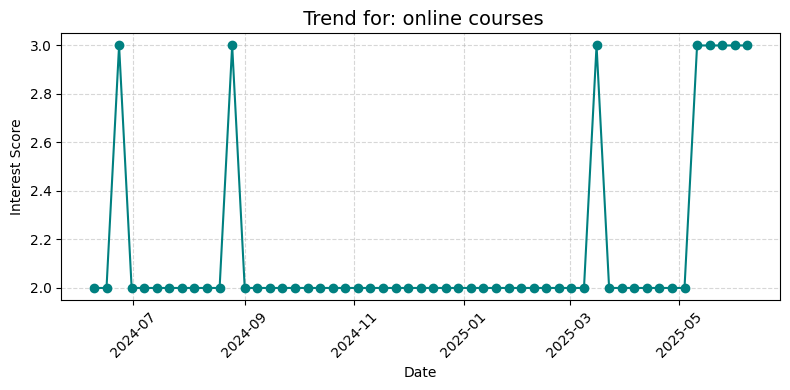

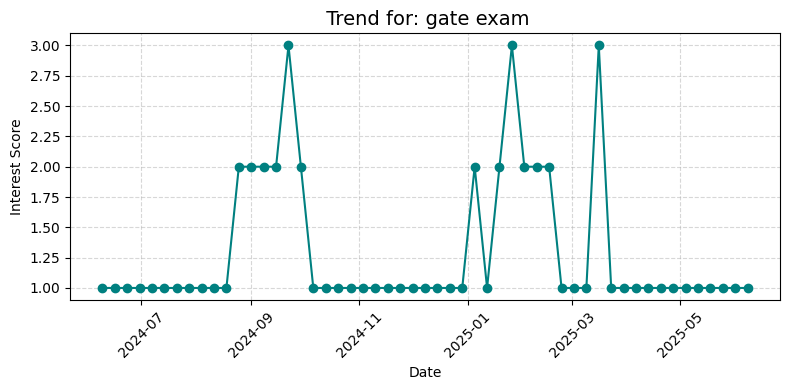

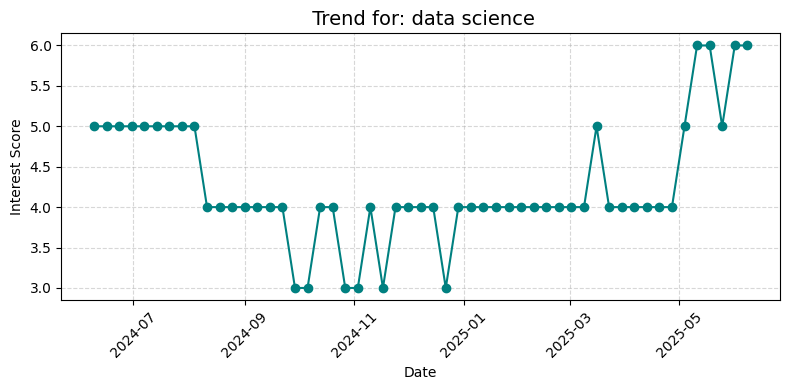

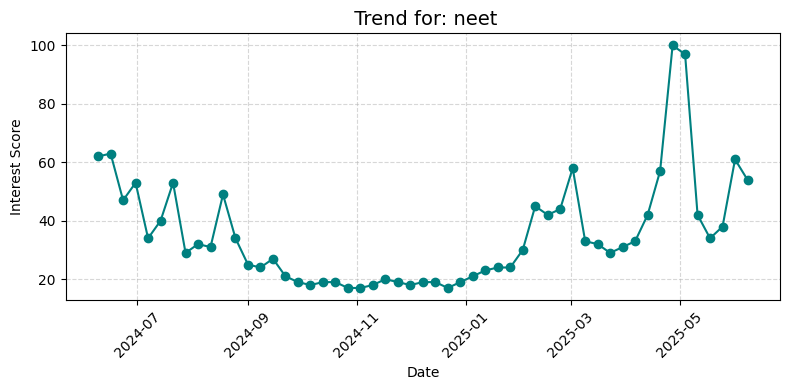

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Step 1: Load Data
df = pd.read_csv('/content/drive/MyDrive/Education/clean_time.csv')
df['date'] = pd.to_datetime(df['date'])

# Step 2: Drop 'date' column from keyword analysis
keywords_df = df.drop(columns=['date'])

# ===============================
# 🔹 1. Average Interest per Keyword
# ===============================
print(" Average Interest per Keyword:")
avg_interest = keywords_df.mean().sort_values(ascending=False)
for keyword, score in avg_interest.items():
    print(f"{keyword:<20}: {score:.2f}")

# ===============================
# 🔹 2. Trend Shape Analysis (Slope)
# ===============================
print("\n Trend Shape Analysis (Slope of Trend Over Time):")
for col in keywords_df.columns:
    slope, _, _, _, _ = linregress(df['date'].map(pd.Timestamp.toordinal), df[col])
    trend = 'Increasing ' if slope > 0 else ('Decreasing ' if slope < 0 else 'Stable ➖')
    print(f"{col:<20}: {trend} (slope = {slope:.2f})")

# ===============================
# 🔹 3. Peak Interest Date per Keyword
# ===============================
print("\n Peak Interest Date per Keyword:")
for col in keywords_df.columns:
    peak_idx = df[col].idxmax()
    peak_date = df.loc[peak_idx, 'date']
    peak_value = df[col].max()
    print(f"{col:<20}: {peak_date.date()} (score = {peak_value})")

# ===============================
# 🔹 4.  Individual Line Charts for Each Keyword
# ===============================
for col in keywords_df.columns:
    plt.figure(figsize=(8, 4))
    plt.plot(df['date'], df[col], marker='o', color='teal')
    plt.title(f" Trend for: {col}", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Interest Score")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


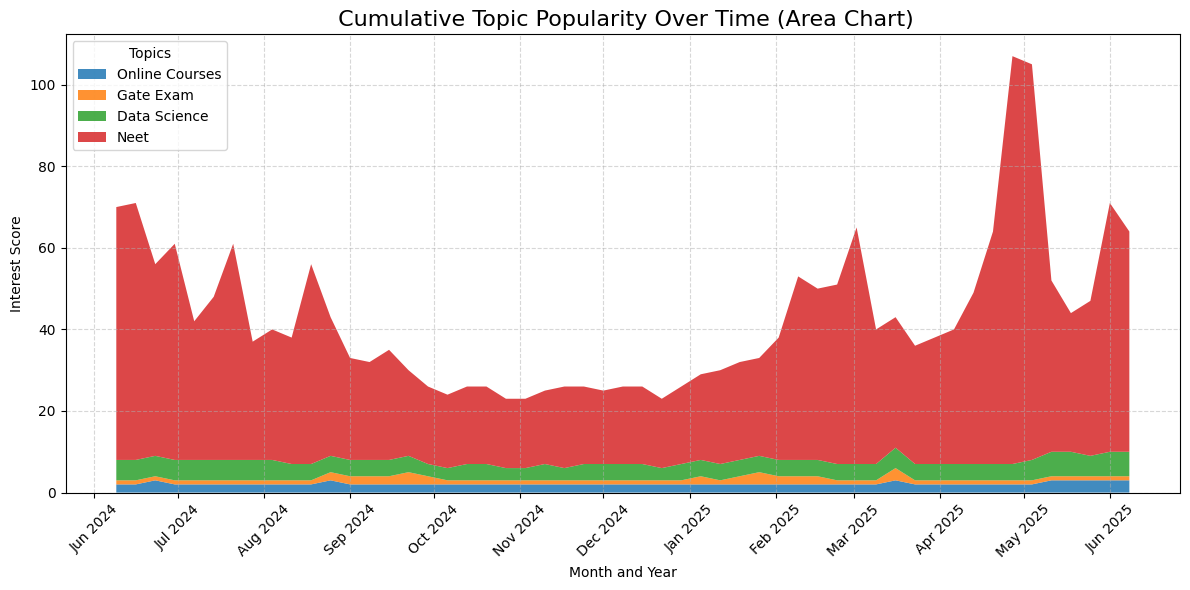

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Step 1: Prepare data
dates = df['date']
topics = df.columns[1:]
scores = df[topics]

# Step 2: Plot Area Chart
plt.figure(figsize=(12, 6))
plt.stackplot(dates, scores.T, labels=[col.title() for col in topics], alpha=0.85)

# Step 3: Format X-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Example: Jan 2024
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Show every month

# Step 4: Style and Labels
plt.title(" Cumulative Topic Popularity Over Time (Area Chart)", fontsize=16)
plt.xlabel("Month and Year")
plt.ylabel("Interest Score")
plt.legend(title="Topics", loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipython-input-3581661366.py:8: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)


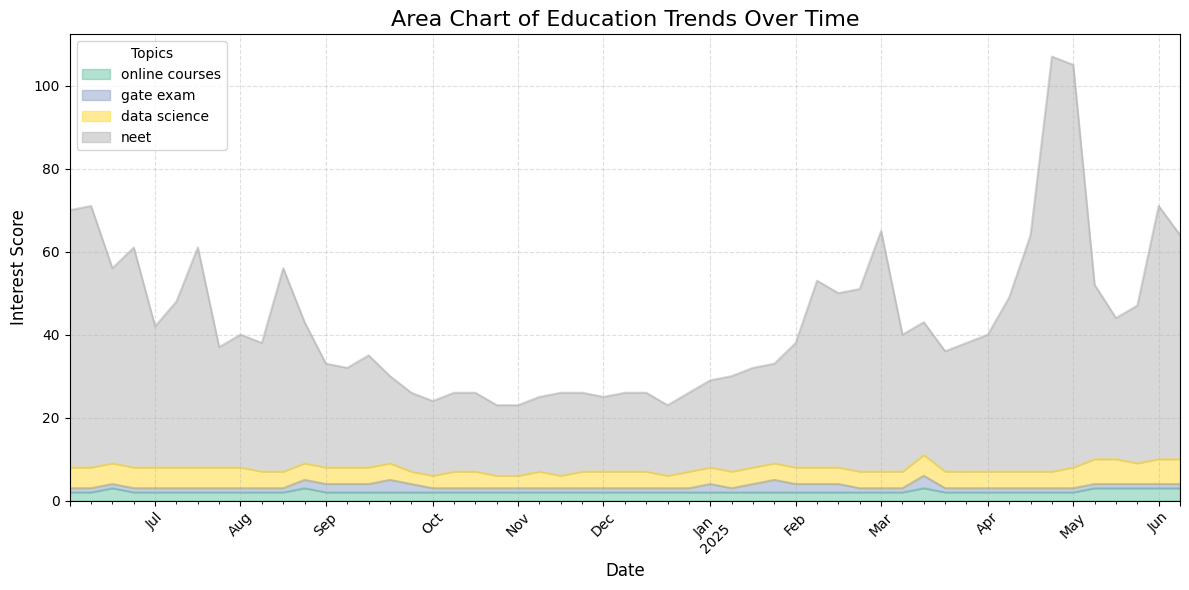

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV
df = pd.read_csv('/content/drive/MyDrive/Education/clean_time.csv')

# Convert 'date' to datetime
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

# Set date as index
df.set_index('date', inplace=True)

# Plot area chart
df.plot(kind='area', alpha=0.5, figsize=(12, 6), stacked=True, cmap='Set2')

# Style the plot
plt.title('Area Chart of Education Trends Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Interest Score', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(title='Topics', loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


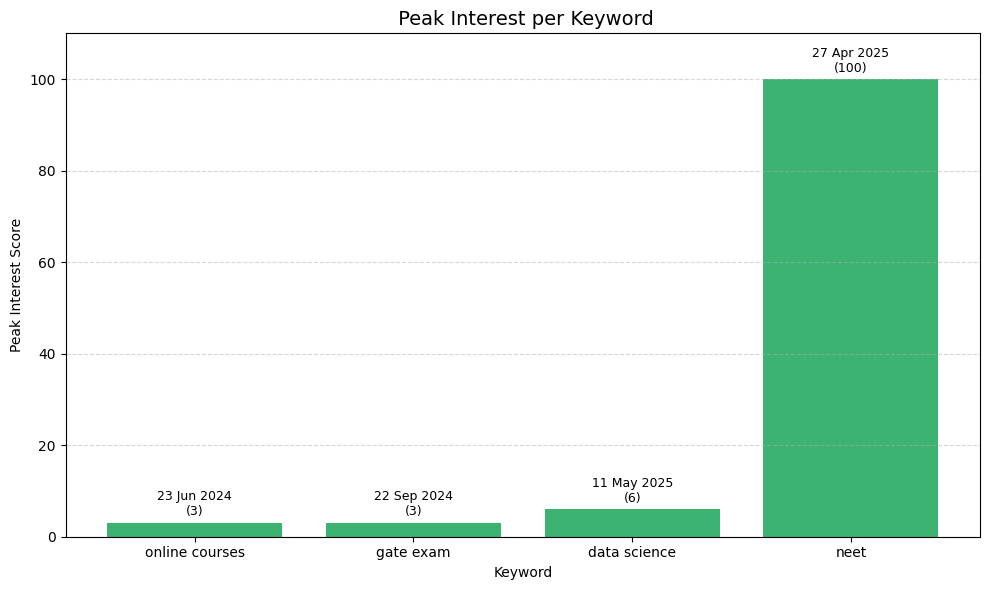

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

#  Load CSV and let pandas auto-parse ISO format dates (YYYY-MM-DD)
df = pd.read_csv('/content/drive/MyDrive/Education/clean_time.csv')
df['date'] = pd.to_datetime(df['date'])  # no format needed

# Drop 'date' for keyword-only analysis
keywords_df = df.drop(columns=['date'])

# Collect peak data
peak_data = {}
for col in keywords_df.columns:
    peak_idx = df[col].idxmax()
    peak_date = df.loc[peak_idx, 'date']
    peak_data[col] = {
        'score': df[col].max(),
        'date': peak_date.strftime('%d %b %Y')  # format like "09 Jun 2024"
    }

#  Prepare data for plotting
topics = list(peak_data.keys())
scores = [peak_data[k]['score'] for k in topics]
dates = [peak_data[k]['date'] for k in topics]

# Plot bar chart with peak dates
plt.figure(figsize=(10, 6))
bars = plt.bar(topics, scores, color='mediumseagreen')
plt.title(" Peak Interest per Keyword", fontsize=14)
plt.xlabel("Keyword")
plt.ylabel("Peak Interest Score")
plt.ylim(0, max(scores) + 10)
plt.grid(axis='y', linestyle='--', alpha=0.5)

#  Annotate each bar with the date and score
for bar, date, score in zip(bars, dates, scores):
    plt.text(bar.get_x() + bar.get_width() / 2, score + 1,
             f"{date}\n({score})", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


/tmp/ipython-input-3523579617.py:8: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)


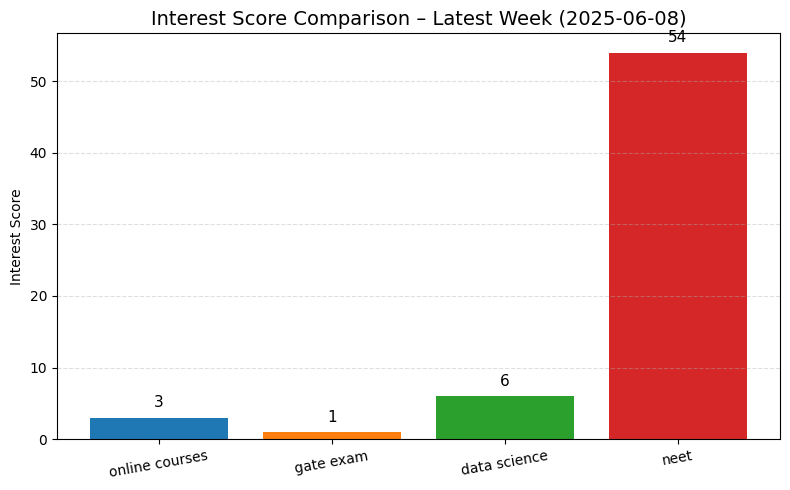

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the data
df = pd.read_csv('/content/drive/MyDrive/Education/clean_time.csv')

# Step 2: Convert 'date' column to datetime (auto format detection)
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

# Step 3: Get the latest row (most recent date)
latest_row = df.iloc[-1]
latest_date = latest_row['date']
latest_scores = latest_row.drop('date')

# Step 4: Plot Bar Chart
plt.figure(figsize=(8, 5))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # You can add more if you have more topics

bars = plt.bar(latest_scores.index, latest_scores.values, color=colors)

# Step 5: Annotate bars with values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{int(yval)}',
             ha='center', va='bottom', fontsize=11)

# Step 6: Style chart
plt.title(f"Interest Score Comparison – Latest Week ({latest_date.date()})", fontsize=14)
plt.ylabel("Interest Score")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.xticks(rotation=10)
plt.tight_layout()
plt.show()


/tmp/ipython-input-2679655161.py:6: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)


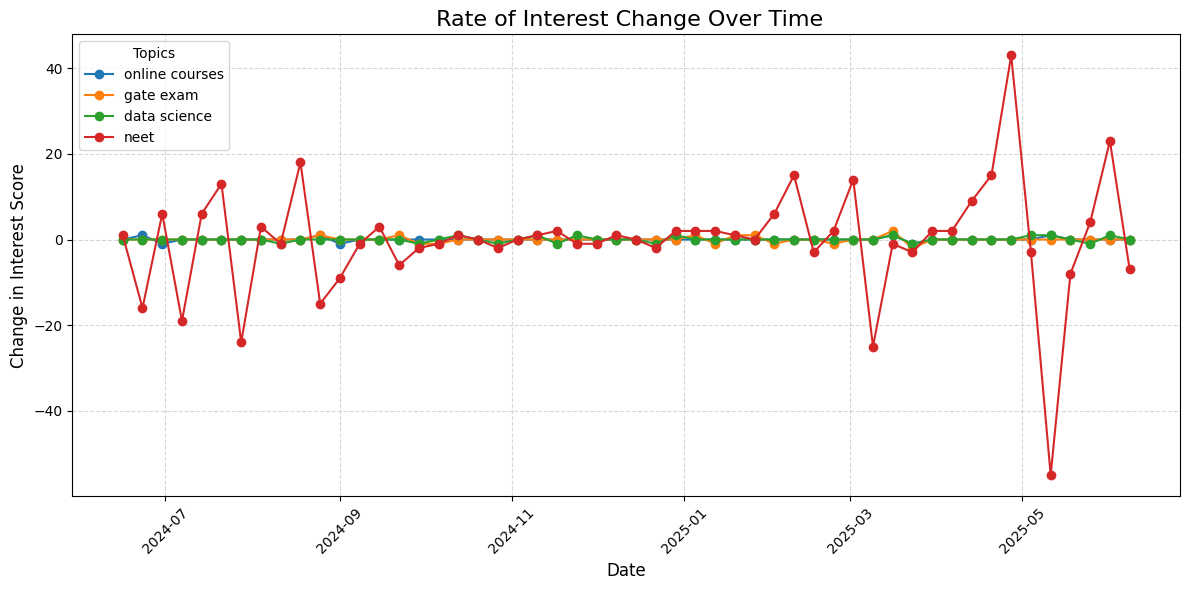

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and prepare data
df = pd.read_csv('/content/drive/MyDrive/Education/clean_time.csv')
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
df.set_index('date', inplace=True)

# Compute first derivative (change in interest)
df_derivative = df.diff()

# Plot rate of change
plt.figure(figsize=(12, 6))
for col in df_derivative.columns:
    plt.plot(df_derivative.index, df_derivative[col], marker='o', label=col)

# Chart styling
plt.title(' Rate of Interest Change Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Change in Interest Score', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.legend(title='Topics', loc='upper left')
plt.tight_layout()
plt.show()


/tmp/ipython-input-2930049609.py:34: UserWarning: Glyph 127849 (\N{DOUGHNUT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127849 (\N{DOUGHNUT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


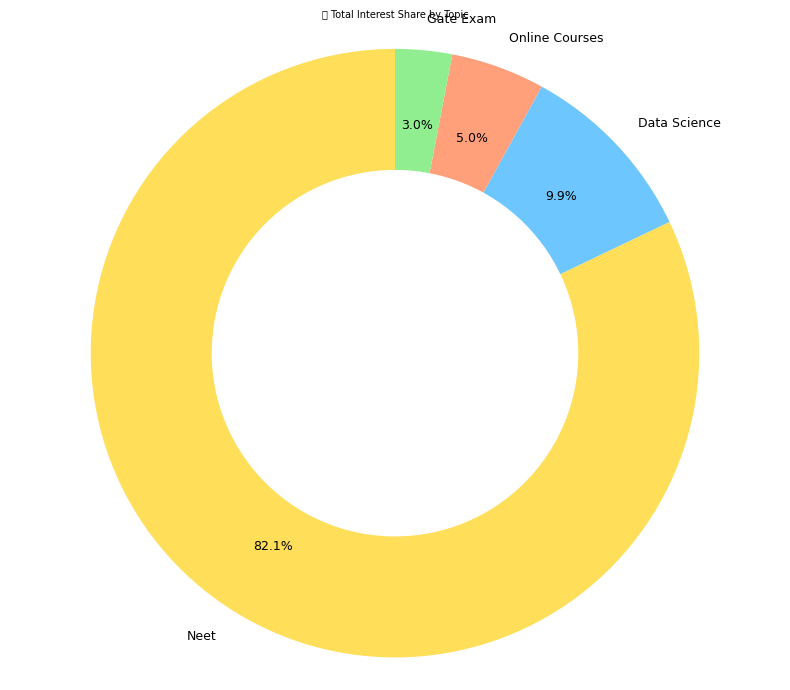

📊 Total Interest Score per Topic:


,Total Score
Neet,1876
Data Science,226
Online Courses,114
Gate Exam,69


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and prepare data
df = pd.read_csv('/content/drive/MyDrive/Education/clean_time.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Topics of interest (clean column names if needed)
df.columns = df.columns.str.strip().str.lower()
topics = ['neet', 'online courses', 'gate exam', 'data science']
sum_interest = df[topics].sum().sort_values(ascending=False)

# Donut chart
fig, ax = plt.subplots(figsize=(8, 7))
colors = ['#FFDE59', '#6EC6FF', '#FFA07A', '#90EE90']
wedges, texts, autotexts = ax.pie(
    sum_interest,
    labels=[label.title() for label in sum_interest.index],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    pctdistance=0.75,
    textprops={'fontsize': 9}
)

# Draw center circle
centre_circle = plt.Circle((0, 0), 0.60, color='white')
ax.add_artist(centre_circle)

# Title and layout
plt.title('🍩 Total Interest Share by Topic', fontsize=7)
plt.axis('equal')  # Equal aspect ratio ensures pie is circular
plt.tight_layout()
plt.show()

# Print total values as a table
print("📊 Total Interest Score per Topic:")
display(sum_interest.rename(str.title).to_frame('Total Score'))


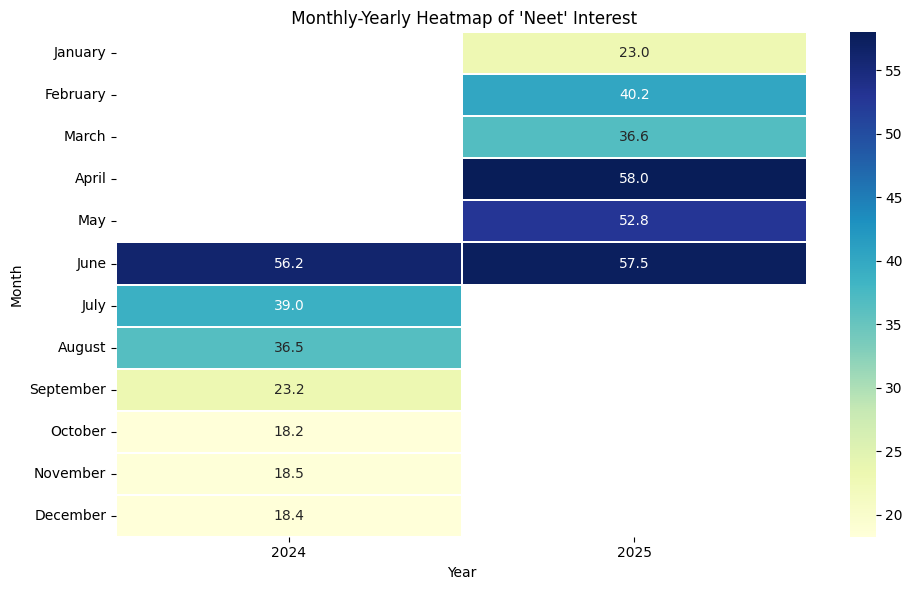

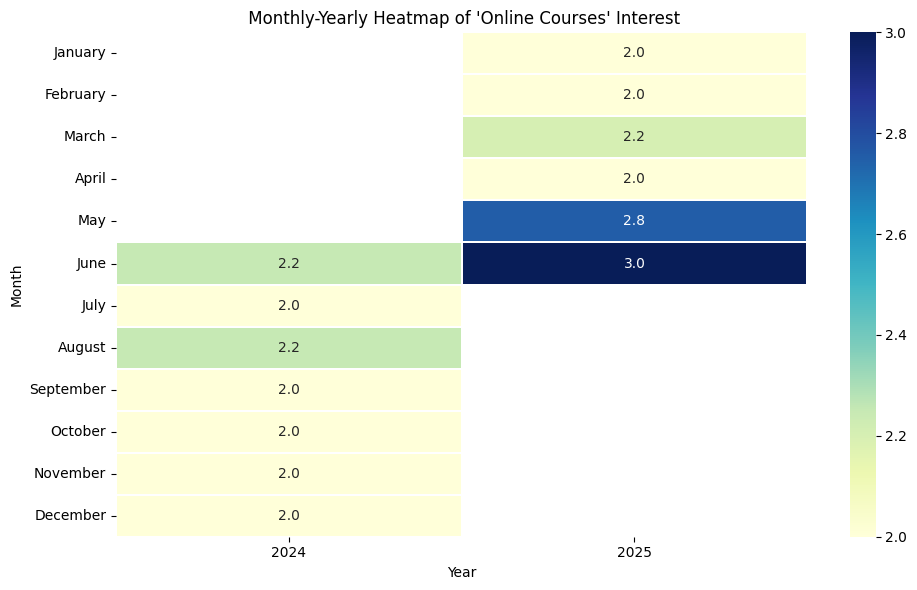

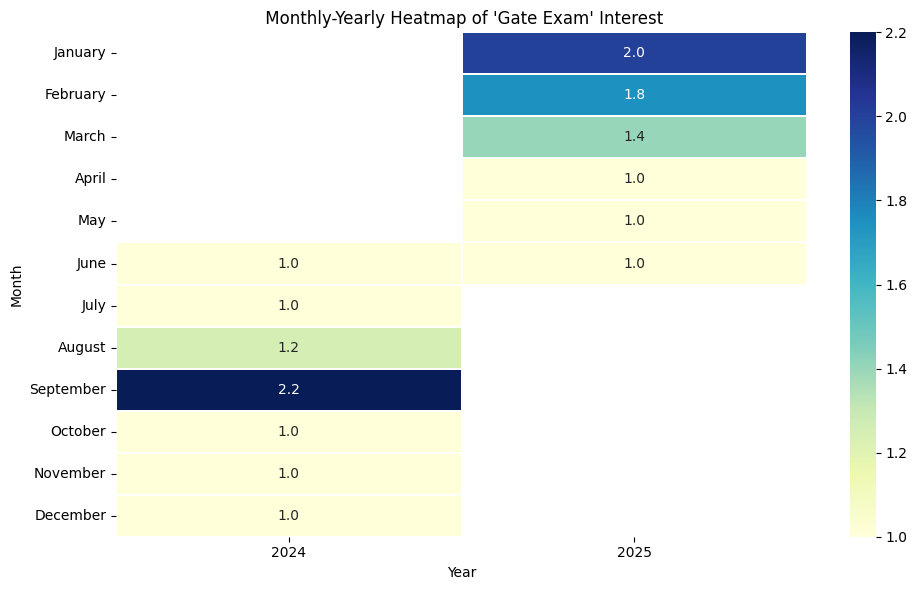

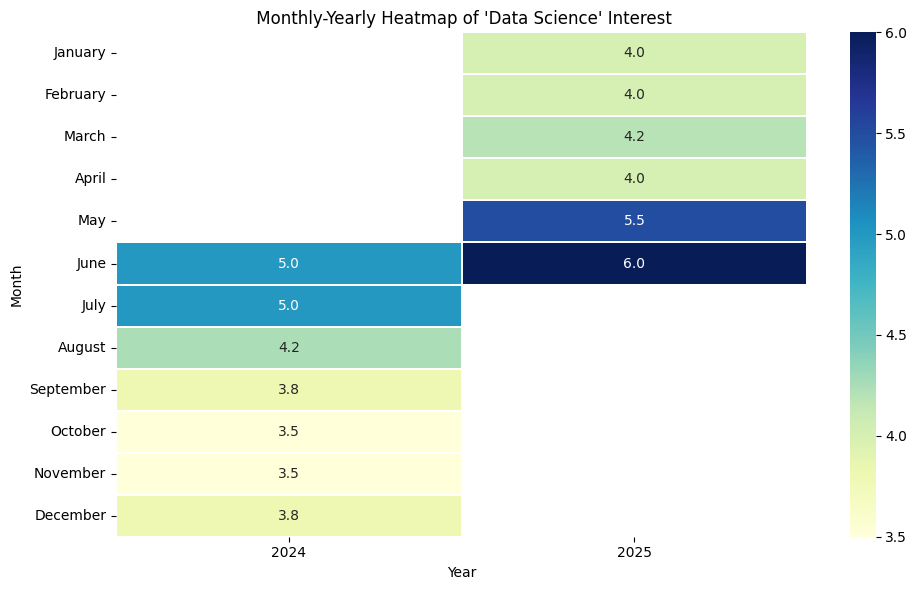

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by Year and Month properly
df['year'] = df.index.year
df['month'] = df.index.month_name()

# Create pivot table
pivot_df = df.pivot_table(index='month', columns='year', values=topics, aggfunc='mean')

# Optional: reorder months
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
pivot_df = pivot_df.reindex(month_order)

# Plot heatmap for each topic
for topic in topics:
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_df[topic], annot=True, fmt='.1f', cmap='YlGnBu', linewidths=0.3)
    plt.title(f" Monthly-Yearly Heatmap of '{topic.title()}' Interest")
    plt.xlabel("Year")
    plt.ylabel("Month")
    plt.tight_layout()
    plt.show()


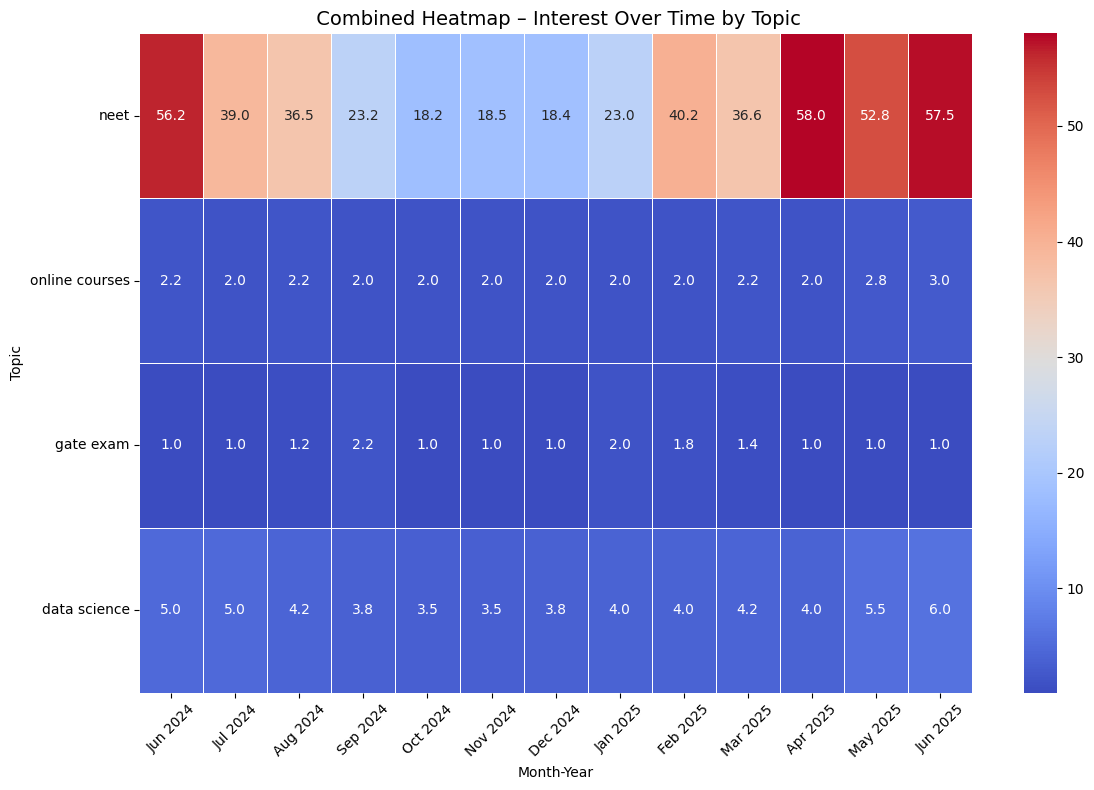

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reload and prepare data
df = pd.read_csv('/content/drive/MyDrive/Education/clean_time.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Add month and year columns
df['Year'] = df.index.year
df['Month'] = df.index.strftime('%b')  # Short month name like Jan, Feb
df['Month_Num'] = df.index.month       # For ordering

# Topics to include
topics = ['neet', 'online courses', 'gate exam', 'data science']

# Melt the dataframe for Seaborn-friendly format
melted = df.reset_index().melt(id_vars=['Month', 'Year', 'Month_Num'], value_vars=topics,
                               var_name='Topic', value_name='Interest')

# Create pivot table with month-year as index and topics as columns
pivot = melted.pivot_table(index=['Year', 'Month_Num', 'Month'], columns='Topic', values='Interest', aggfunc='mean')

# Reset and sort index to get proper order
pivot = pivot.reset_index().sort_values(['Year', 'Month_Num'])

# Create month-year string for final index
pivot['Month_Year'] = pivot['Month'] + ' ' + pivot['Year'].astype(str)
pivot.set_index('Month_Year', inplace=True)

# Final DataFrame for heatmap
heatmap_data = pivot[topics]

# Plot combined heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data.T, annot=True, fmt='.1f', cmap='coolwarm', linewidths=0.5)
plt.title(" Combined Heatmap – Interest Over Time by Topic", fontsize=14)
plt.xlabel("Month-Year")
plt.ylabel("Topic")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# **Visuals interest by city**

In [ ]:
# interset by city

In [ ]:
import pandas as pd

# Load city-wise interest data
city_df = pd.read_csv('/content/drive/MyDrive/Education/clean_city.csv')

# Display basic info
print(city_df.head())


                       geoname  online courses  gate exam  data science  neet
0  Andaman and Nicobar Islands               5          0             4    91
1               Andhra Pradesh               5          5            14    76
2            Arunachal Pradesh               2          2             3    93
3                        Assam               3          3             4    90
4                        Bihar               2          2             4    92


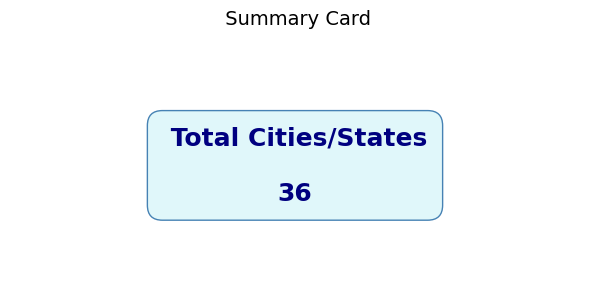

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load city-wise interest data
city_df = pd.read_csv('/content/drive/MyDrive/Education/clean_city.csv')

# Compute total interest
city_df['Total Interest'] = city_df[['neet', 'online courses', 'gate exam', 'data science']].sum(axis=1)

# Count total cities (or rows)
total_cities = city_df.shape[0]

# Plot a simple card using a figure and text
plt.figure(figsize=(6, 3))
plt.axis('off')  # Turn off axis

# Draw the "card"
plt.text(0.5, 0.5,
         f" Total Cities/States\n\n{total_cities}",
         fontsize=18,
         fontweight='bold',
         color='navy',
         ha='center',
         va='center',
         bbox=dict(boxstyle="round,pad=0.6", facecolor="#E0F7FA", edgecolor="steelblue"))

plt.title(" Summary Card", fontsize=14, pad=20)
plt.tight_layout()
plt.show()


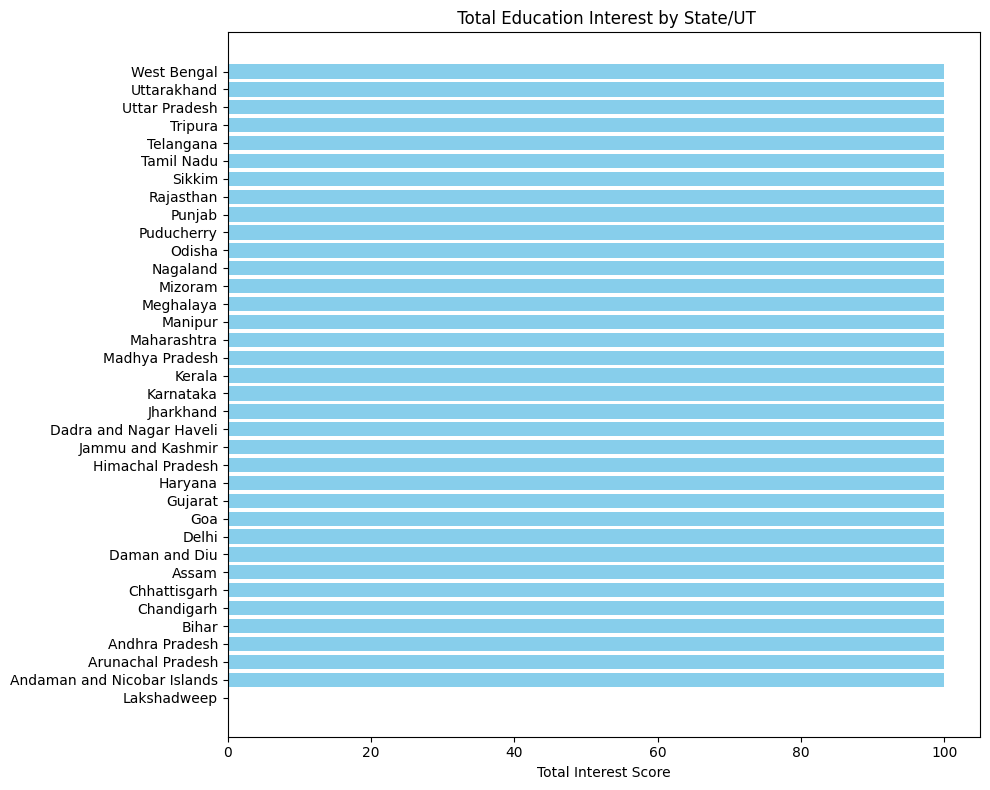

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load city-wise interest data
city_df = pd.read_csv('/content/drive/MyDrive/Education/clean_city.csv')

# Compute total interest
city_df['Total Interest'] = city_df[['neet', 'online courses', 'gate exam', 'data science']].sum(axis=1)

# Sort by total interest (low to high)
sorted_df = city_df.sort_values('Total Interest', ascending=True)

# Horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(sorted_df['geoname'], sorted_df['Total Interest'], color='skyblue')
plt.xlabel("Total Interest Score")
plt.title(" Total Education Interest by State/UT")
plt.tight_layout()
plt.show()



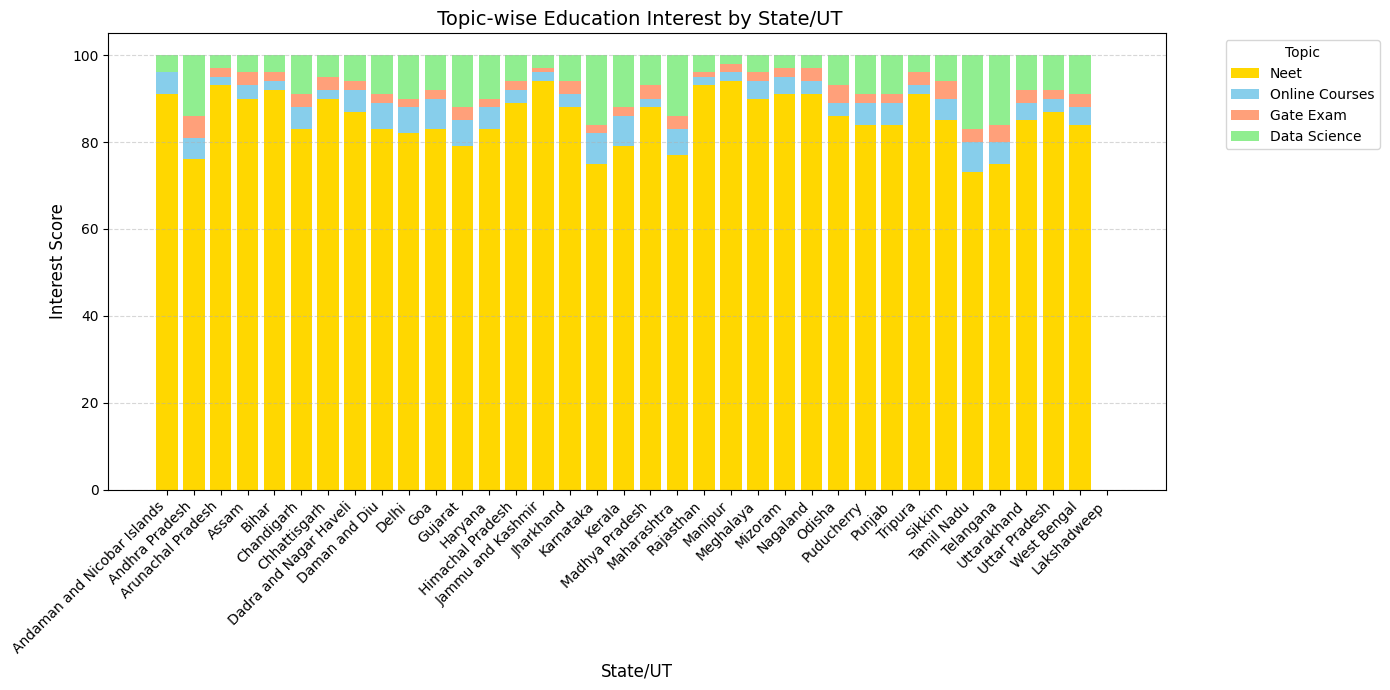

In [ ]:
import matplotlib.pyplot as plt

# Sort the DataFrame by total interest descending
sorted_df = city_df.sort_values('Total Interest', ascending=False)

# Define topic columns (use lowercase to match your DataFrame)
topic_cols = ['neet', 'online courses', 'gate exam', 'data science']
colors = ['#FFD700', '#87CEEB', '#FFA07A', '#90EE90']  # Custom color palette

# Plot stacked bar chart
plt.figure(figsize=(14, 7))
bottom = [0] * len(sorted_df)

for topic, color in zip(topic_cols, colors):
    plt.bar(sorted_df['geoname'], sorted_df[topic], label=topic.title(), bottom=bottom, color=color)
    bottom = [i + j for i, j in zip(bottom, sorted_df[topic])]

# Formatting
plt.title(" Topic-wise Education Interest by State/UT", fontsize=14)
plt.xlabel("State/UT", fontsize=12)
plt.ylabel("Interest Score", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


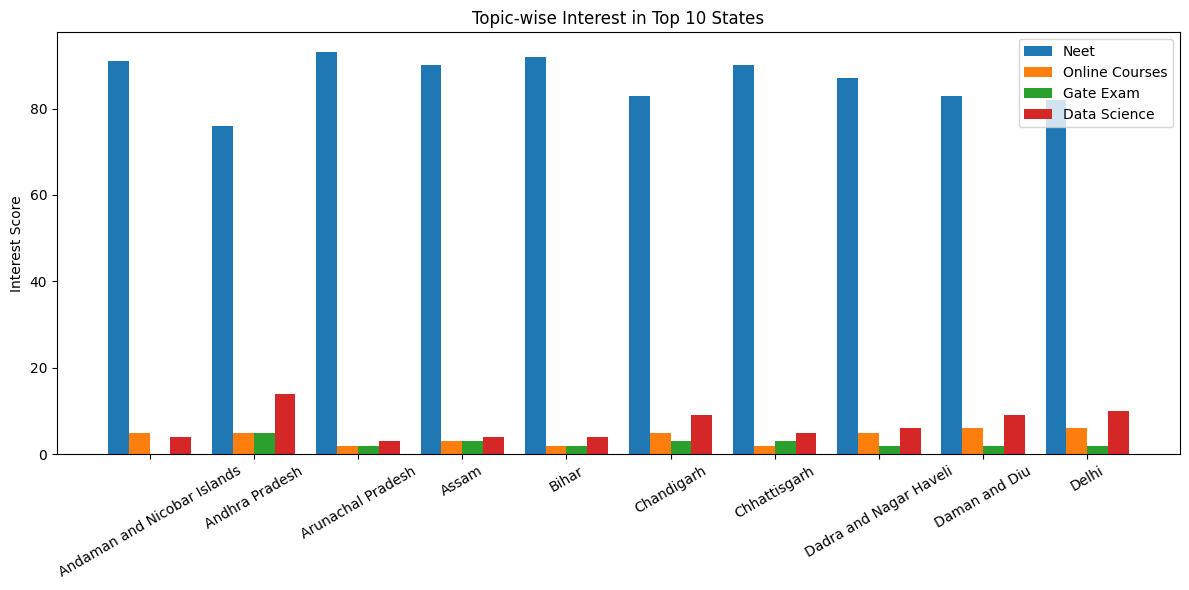

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Top 10 states by total interest
top10_states = city_df.sort_values('Total Interest', ascending=False).head(10)

# Grouped bar chart
import numpy as np

x = np.arange(len(top10_states['geoname']))
width = 0.2

plt.figure(figsize=(12, 6))
for i, topic in enumerate(topics):
    plt.bar(x + i * width, top10_states[topic], width, label=topic.title())

plt.xticks(x + width*1.5, top10_states['geoname'], rotation=30)
plt.ylabel("Interest Score")
plt.title("Topic-wise Interest in Top 10 States")
plt.legend()
plt.tight_layout()
plt.show()


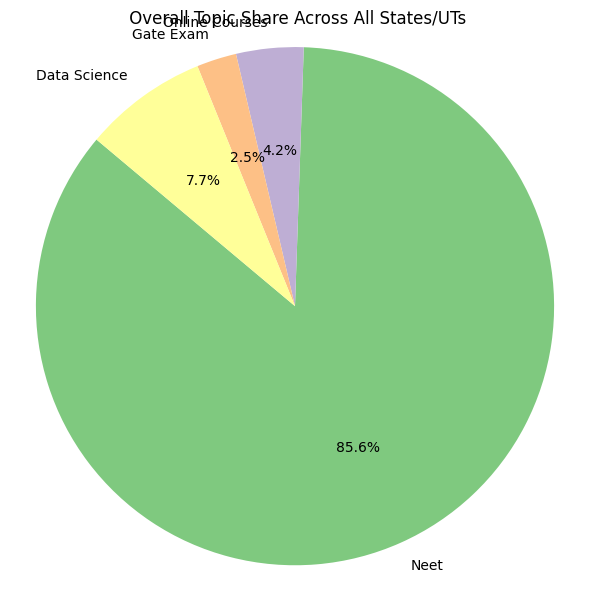

In [ ]:
topic_totals = city_df[topic_cols].sum()

plt.figure(figsize=(6, 6))
plt.pie(topic_totals, labels=[t.title() for t in topic_cols], autopct='%1.1f%%', startangle=140, colors=plt.cm.Accent.colors)
plt.title(" Overall Topic Share Across All States/UTs")
plt.axis('equal')
plt.tight_layout()
plt.show()

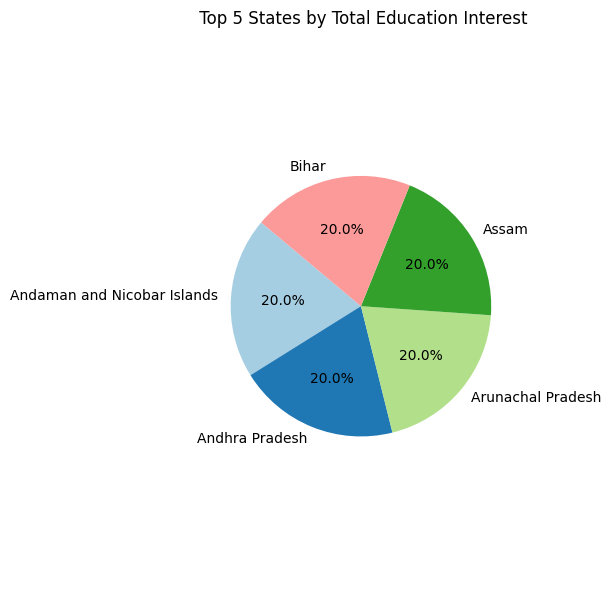

In [ ]:
import matplotlib.pyplot as plt

top5 = city_df.sort_values("Total Interest", ascending=False).head(5)

plt.figure(figsize=(6, 6))
plt.pie(top5['Total Interest'], labels=top5['geoname'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title(" Top 5 States by Total Education Interest")
plt.axis('equal')  # Equal aspect ratio ensures pie is circular.
plt.tight_layout()
plt.show()


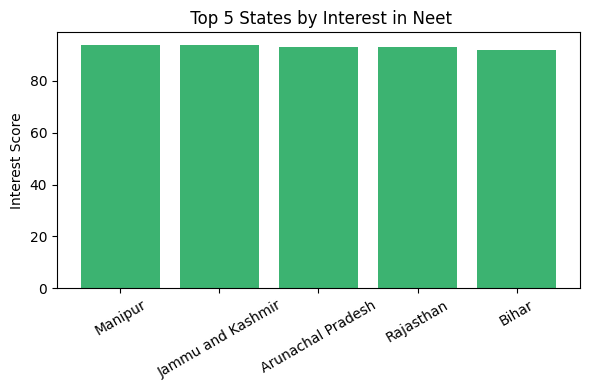

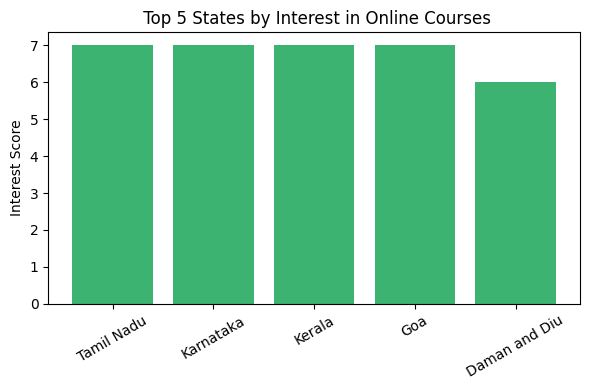

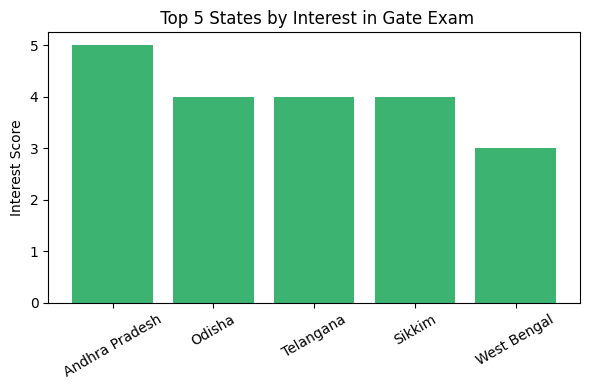

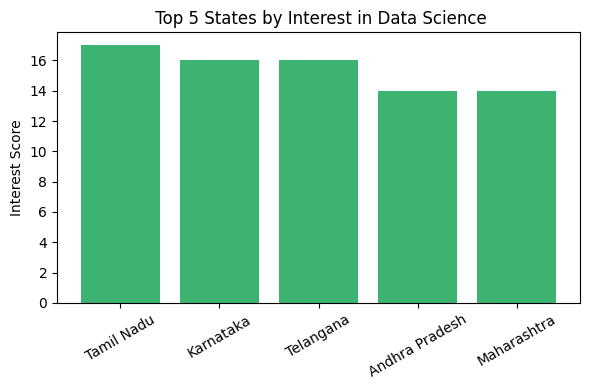

In [ ]:
# Set topic columns
topics = ['neet', 'online courses', 'gate exam', 'data science']

# Plot top 5 states per topic
for topic in topics:
    top5 = city_df[['geoname', topic]].sort_values(by=topic, ascending=False).head(5)

    plt.figure(figsize=(6, 4))
    plt.bar(top5['geoname'], top5[topic], color='mediumseagreen')
    plt.title(f" Top 5 States by Interest in {topic.title()}")
    plt.ylabel("Interest Score")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


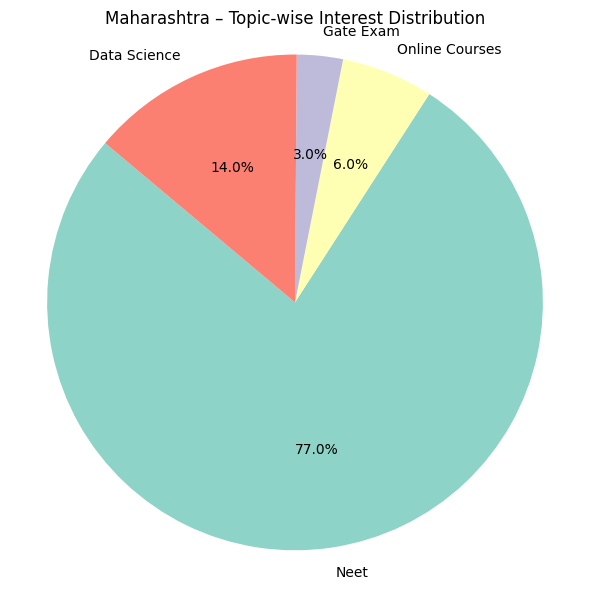

In [ ]:
state = "Maharashtra"
single = city_df[city_df['geoname'] == state][topic_cols].squeeze()

plt.figure(figsize=(6, 6))
plt.pie(single, labels=[t.title() for t in topic_cols], autopct='%1.1f%%', startangle=140, colors=plt.cm.Set3.colors)
plt.title(f"{state} – Topic-wise Interest Distribution")
plt.axis('equal')
plt.tight_layout()
plt.show()


In [ ]:
state = "Maharashtra"

# Filter row for Maharashtra (case-insensitive match)
maha_data = city_df[city_df['geoname'].str.lower() == state.lower()][topic_cols].squeeze()

# Display the interest values
if maha_data.empty:
    print(f"No data found for state: {state}")
else:
    print(f" Interest Scores for {state}:")
    for topic in topic_cols:
        print(f" {topic.title()}: {maha_data[topic]}")


 Interest Scores for Maharashtra:
 Neet: 77
 Online Courses: 6
 Gate Exam: 3
 Data Science: 14


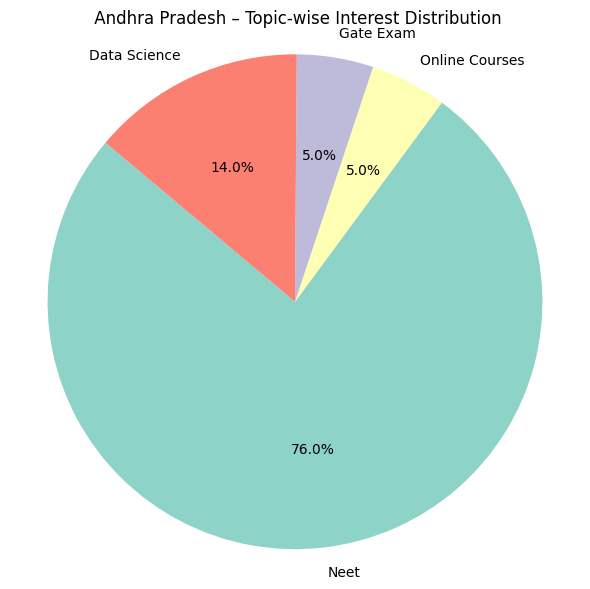

In [ ]:
state = "Andhra Pradesh"
single = city_df[city_df['geoname'] == state][topic_cols].squeeze()

plt.figure(figsize=(6, 6))
plt.pie(single, labels=[t.title() for t in topic_cols], autopct='%1.1f%%', startangle=140, colors=plt.cm.Set3.colors)
plt.title(f" {state} – Topic-wise Interest Distribution")
plt.axis('equal')
plt.tight_layout()
plt.show()


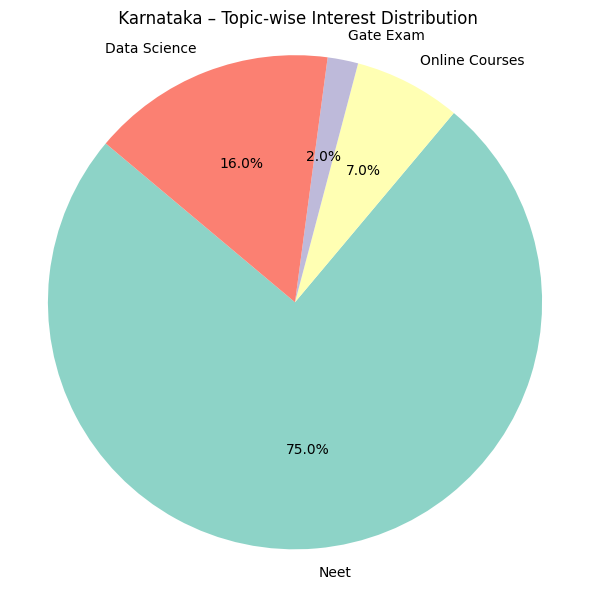

In [ ]:
import matplotlib.pyplot as plt

#  Corrected state name
state = "Karnataka"

# Extract topic values safely
single = city_df[city_df['geoname'].str.lower() == state.lower()][topic_cols].squeeze()

# Check if valid data was found
if single.empty:
    print(f"No data found for state: {state}")
else:
    plt.figure(figsize=(6, 6))
    plt.pie(
        single,
        labels=[t.title() for t in topic_cols],
        autopct='%1.1f%%',
        startangle=140,
        colors=plt.cm.Set3.colors
    )
    plt.title(f" {state} – Topic-wise Interest Distribution")
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


In [ ]:
state = "Karnataka"
topic = "data science"

# Get interest score
score = city_df.loc[city_df['geoname'].str.lower() == state.lower(), topic].squeeze()

# Print result
print(f" Interest Score for '{topic.title()}' in {state}: {score}")


 Interest Score for 'Data Science' in Karnataka: 16


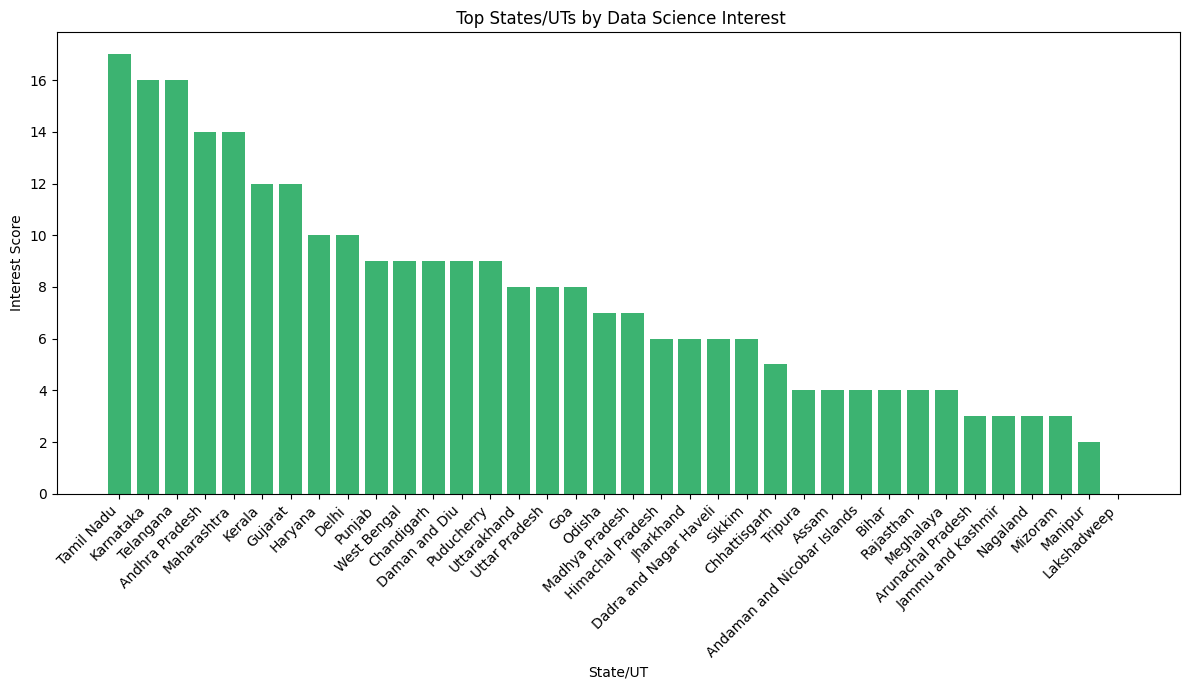

In [ ]:
# Sort states by Data Science interest
sorted_ds = city_df.sort_values('data science', ascending=False)

plt.figure(figsize=(12, 7))
plt.bar(sorted_ds['geoname'], sorted_ds['data science'], color='mediumseagreen')
plt.xticks(rotation=45, ha='right')
plt.xlabel("State/UT")
plt.ylabel("Interest Score")
plt.title(" Top States/UTs by Data Science Interest")
plt.tight_layout()
plt.show()


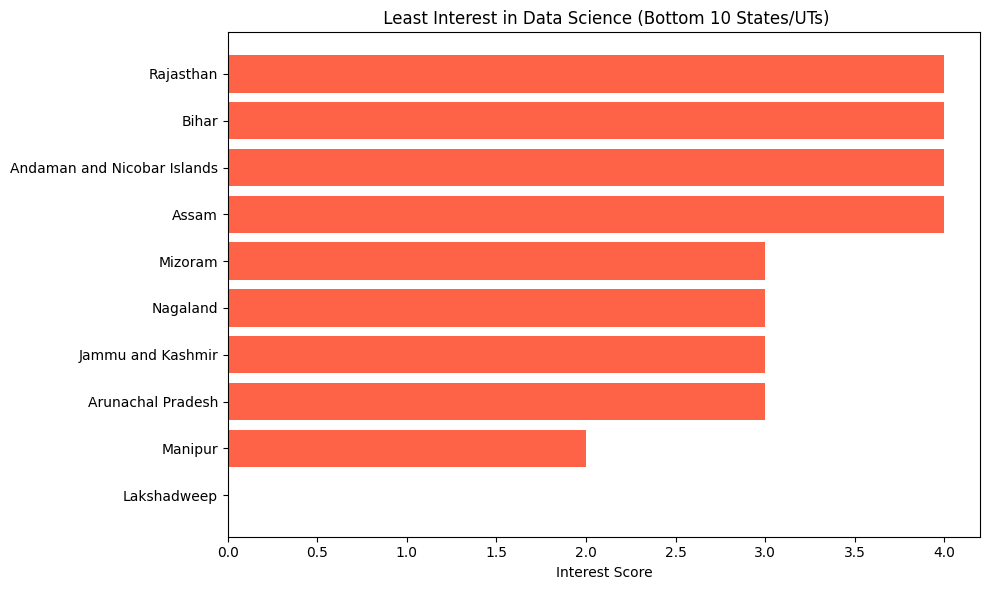

In [ ]:
bottom_ds = city_df.sort_values('data science', ascending=True).head(10)

plt.figure(figsize=(10, 6))
plt.barh(bottom_ds['geoname'], bottom_ds['data science'], color='tomato')
plt.xlabel("Interest Score")
plt.title(" Least Interest in Data Science (Bottom 10 States/UTs)")
plt.tight_layout()
plt.show()


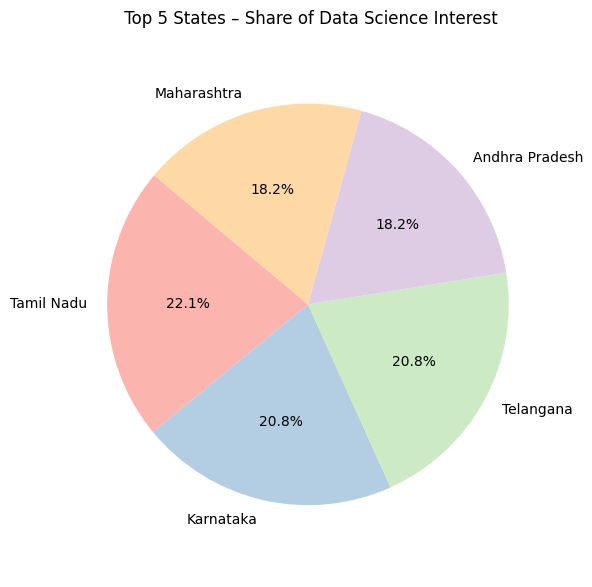

In [ ]:
top5_ds = city_df.sort_values('data science', ascending=False).head(5)

plt.figure(figsize=(6, 6))
plt.pie(
    top5_ds['data science'],
    labels=top5_ds['geoname'],
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Pastel1.colors
)
plt.title(" Top 5 States – Share of Data Science Interest")
plt.axis('equal')
plt.tight_layout()
plt.show()


In [ ]:
print(" Top 10 States by Data Science Interest:")
print(city_df[['geoname', 'data science']].sort_values('data science', ascending=False).head(10))


 Top 10 States by Data Science Interest:
           geoname  data science
30      Tamil Nadu            17
16       Karnataka            16
31       Telangana            16
1   Andhra Pradesh            14
20     Maharashtra            14
17          Kerala            12
11         Gujarat            12
12         Haryana            10
9            Delhi            10
27          Punjab             9


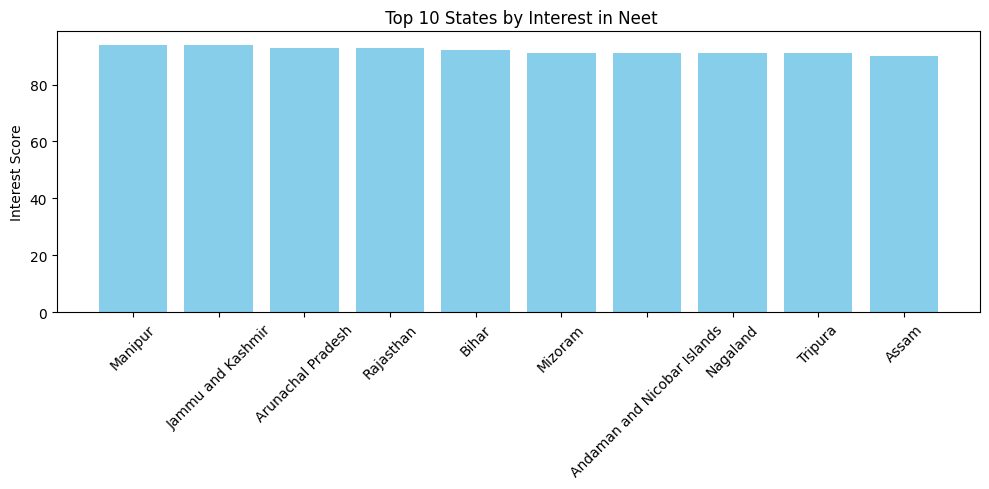

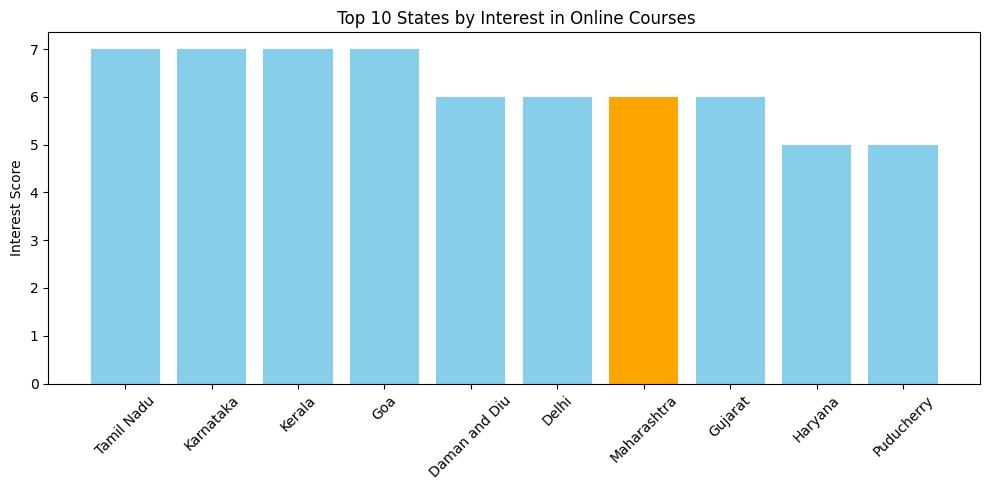

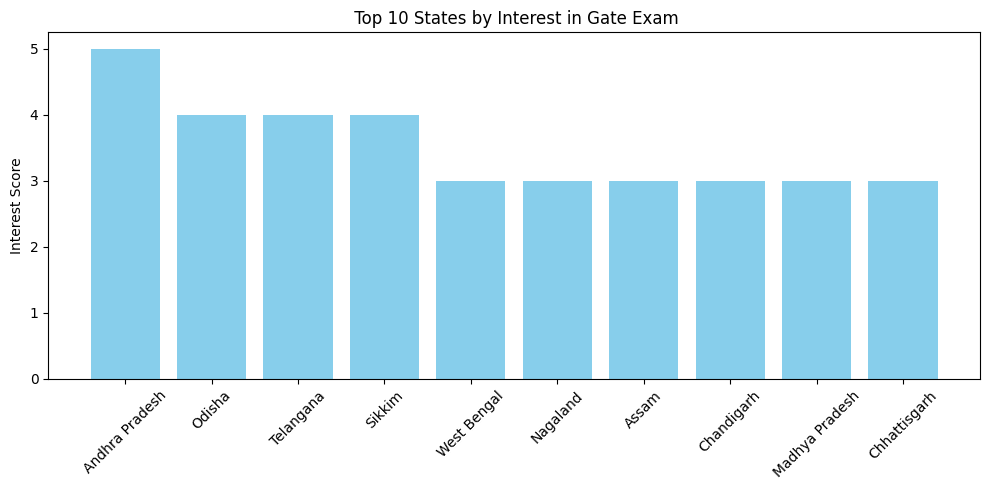

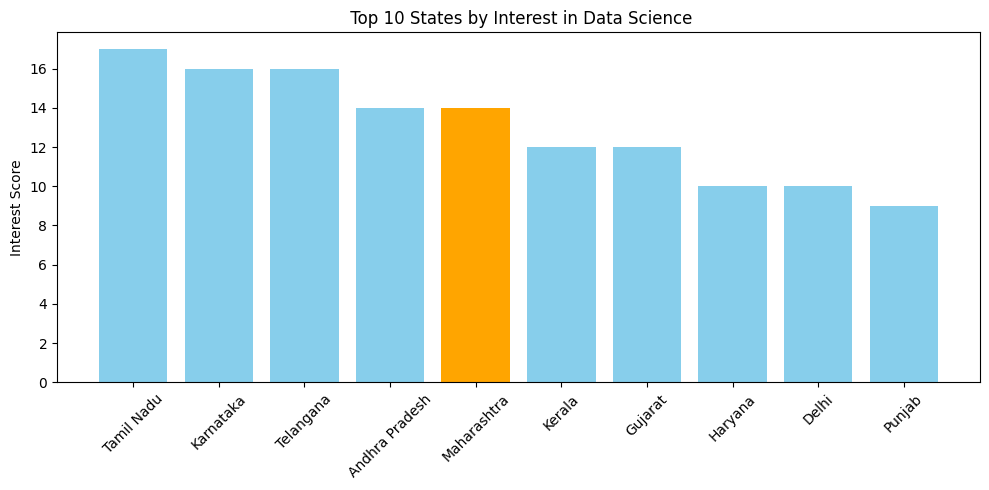

In [ ]:
import matplotlib.pyplot as plt

# Sort by NEET and get top 10 states for NEET
for topic in topic_cols:
    top_states = city_df.sort_values(topic, ascending=False).head(10)

    # Highlight Maharashtra in a different color
    colors = ['skyblue' if state != 'Maharashtra' else 'orange' for state in top_states['geoname']]

    # Plot
    plt.figure(figsize=(10, 5))
    plt.bar(top_states['geoname'], top_states[topic], color=colors)
    plt.title(f" Top 10 States by Interest in {topic.title()}")
    plt.ylabel("Interest Score")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## **5. Insights & Conclusions**


The analysis showed clear seasonal patterns and event-driven spikes in search interest.  
Technology and shopping terms peak during launches and sales, while health and education align with seasonal needs and exams.  
Some topics stay popular year-round, others fade quickly, and trends vary by region.

From the Google Search Trends analysis, we observed key patterns and seasonal variations in search interest across different categories.  

Notable findings include:  
- **Seasonality:** Certain keywords peak during specific months or events (e.g., exams, festivals, product launches).  
- **Category Insights:** Technology and shopping-related terms show spikes during product releases and sales events, while health and education trends align with seasonal needs and academic calendars.  
- **Popularity Changes:** Some topics maintain consistent interest, while others show short-term spikes followed by rapid declines.  
- **Regional Influence:** Search interest can vary significantly depending on location and local events.  

These insights can help businesses, marketers, and researchers understand audience behavior, plan campaigns, and forecast future interest trends.



## **Objective**
To collect and analyze real-time Google Search Trends data using the Pytrends library across multiple categories. The goal is to identify seasonal patterns, track changes in topic popularity, and provide insights that can guide planning, marketing, and forecasting.

## **Challenges**
- Fetching and handling real-time data from Pytrends without API limitations.
- Cleaning and preprocessing raw trend data for accurate comparisons.
- Identifying meaningful patterns within seasonal and regional variations.
- Managing visual clarity while analyzing multiple categories together.

## **Outcome**
- Successfully gathered real-time search trend data from Pytrends.
- Clear identification of seasonal peaks and event-driven search spikes.
- Recognition of consistent versus short-lived trending topics.
- Insights into category-specific trends (technology, shopping, health, education) that can help in making informed, data-driven decisions.
